In [1]:
#imports 

import pygame
import random
import numpy as np
from scipy import signal

pygame 2.4.0 (SDL 2.26.4, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Step 1: create your phantom

In [2]:
#setting phantom size
phantom_width = 256
phantom_height = 256
 
# Making canvas
screen = pygame.display.set_mode((phantom_width, phantom_height))
screen.fill((255, 255, 255)) # Filling Background with white
 
# Setting Title
pygame.display.set_caption('Draw your phantom')
 
 
draw_on = False
last_pos = (0, 0)
color = (0, 0, 0)  # Initial Color of the Brush
 
# Radius of the Brush
radius = 5
 
 
def roundline(canvas, color, start, end, radius=1):
    Xaxis = end[0]-start[0]
    Yaxis = end[1]-start[1]
    dist = max(abs(Xaxis), abs(Yaxis))
    for i in range(dist):
        x = int(start[0]+float(i)/dist*Xaxis)
        y = int(start[1]+float(i)/dist*Yaxis)
        pygame.draw.circle(canvas, color, (x, y), radius)
 
 
try:
    while True:
        e = pygame.event.wait()
         
        if e.type == pygame.QUIT:
            raise StopIteration
        
        #when r is pressed it will change the brush color to red
        if e.type == pygame.KEYDOWN:
            if e.key == pygame.K_r:
                color = (255, 0, 0)

        #when g is pressed it will change the brush color to green
            if e.key == pygame.K_g:
                color = (0, 255, 0)

        #when b is pressed it will change the brush color to blue
            if e.key == pygame.K_b:
                color = (0, 0, 255)

        #when k is pressed it will change the brush color to black
            if e.key == pygame.K_k:
                color = (0, 0, 0)

        #when x is pressed it will change the brush color to random
            if e.key == pygame.K_x:
                color = (random.randrange(256), random.randrange(
                256), random.randrange(256))

        #if a number key is pressed
            if e.key == pygame.K_1 or e.key == pygame.K_2 or e.key == pygame.K_3 or e.key == pygame.K_4 or e.key == pygame.K_5 or e.key == pygame.K_6 or e.key == pygame.K_7 or e.key == pygame.K_8 or e.key == pygame.K_9:
                #change the brush size to the number pressed
                radius = int(pygame.key.name(e.key))

        if e.type == pygame.MOUSEBUTTONDOWN:    
            # Draw a single circle wheneven mouse is clicked down.
            pygame.draw.circle(screen, color, e.pos, radius)
            draw_on = True
        # When mouse button released it will stop drawing    
        if e.type == pygame.MOUSEBUTTONUP:
            draw_on = False
        # It will draw a continuous circle with the help of roundline function.    
        if e.type == pygame.MOUSEMOTION:
            if draw_on:
                pygame.draw.circle(screen, color, e.pos, radius)
                roundline(screen, color, e.pos, last_pos,  radius)
            last_pos = e.pos
        pygame.display.flip()
        #save the image
        pygame.image.save(screen, "image.png")

 
except StopIteration:
    pass

pygame.quit()


Getting the image

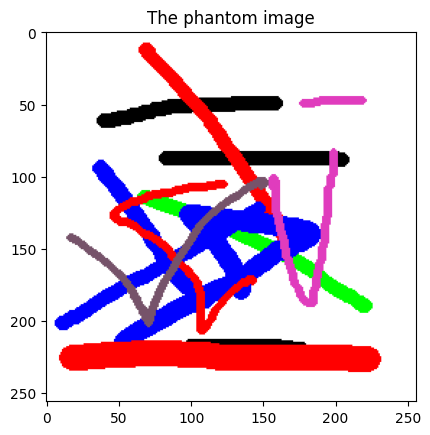

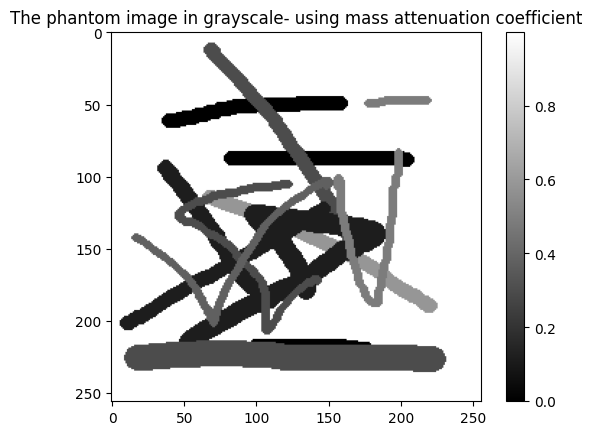

[0.         0.114      0.2989     0.3767655  0.48517491 0.587
 0.9999    ]


In [3]:
#load the image and display it 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('image.png')
imgplot = plt.imshow(img)
plt.title('The phantom image')
plt.show()

#convert the image to grayscale 
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

phantom = rgb2gray(img)
plt.imshow(phantom, cmap = plt.get_cmap('gray'))
plt.title('The phantom image in grayscale- ' 
          'using mass attenuation coefficient')
plt.colorbar()
plt.show()

#print unique values in the phantom
print(np.unique(phantom))

Phantom through source function

In [4]:
#using source function from HW2B
def sourceblur(M, x,y,a):
    #Assume source blur is 2D Gaussian function with e^{-pi (ax)^2-pi (ay)^2}
    #Use formula from class s(-M/m x0)*h_d(Mx0), i.e. this part creates s(-M/m x0)
    m=M-1
    source_o=np.exp(-np.pi*(a*-M/m*x)**2-np.pi*(a*-M/m*y)**2)
    return source_o

In [5]:
# #convolve function
# def convolve(func1, func2):
#     #convolve the source with the phantom - use fft2 is faster than convolve2d
#     convolve = np.fft.ifft2(np.fft.ifft2(func1)*np.fft.ifft2(func2))
#     convolve = np.real(convolve)
#     #shift it to the center
#     convolve = np.fft.fftshift(convolve)    
#     return convolve

def convolve (f1, f2):
    convolve = signal.convolve2d(f1, f2, mode='same')
    return convolve

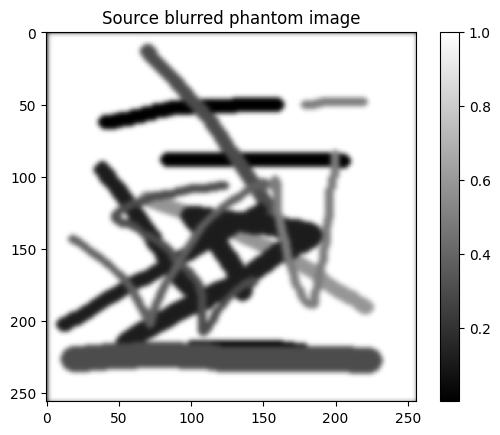

In [6]:
x_range =np.arange(-phantom_width/2,phantom_width/2,1)
y_range = np.arange(-phantom_height/2,phantom_height/2,1)
x,y = np.meshgrid(x_range,y_range)

M = 1.09 #M value for the source/detector setup
source_blur = .02 #a value

#convolve the source with the phantom
source_blur_phantom = convolve(phantom, sourceblur(M,x,y,source_blur))
#reduce the max value to 1
source_blur_phantom = source_blur_phantom/np.max(source_blur_phantom)

#plot the convolved image
plt.imshow(source_blur_phantom, cmap = plt.get_cmap('gray'))
plt.title('Source blurred phantom image')
plt.colorbar()
plt.show()



Add detector blur

In [7]:
#using detector function from HW2B
def detectblur(M, x,y,a):
    #Assume detector blur is 2D Gaussian function with e^{-pi (ax)^2-pi (by)^2}
    #Use formula from class s(-M/m x0)*h_d(Mx0), i.e. this part creates h_d(Mx0)
    detect_o=np.exp(-np.pi*(a*M*x)**2-np.pi*(a*M*y)**2)
    return detect_o

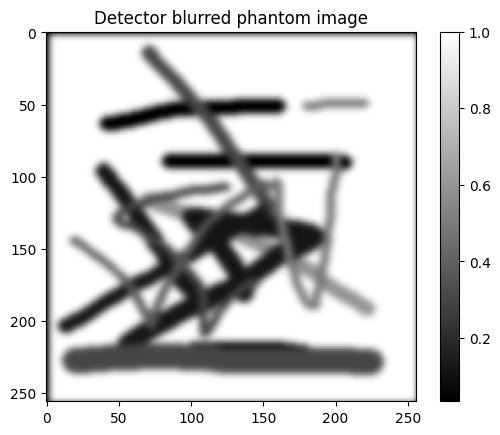

In [8]:
detector_blur = .2 #a value

#convolve the detector with the source blurred phantom
blur_phantom = convolve(source_blur_phantom,detectblur(M,x,y,detector_blur))
#reduce the max value to 1
blur_phantom = blur_phantom/np.max(blur_phantom)

#plot the convolved image
plt.imshow(blur_phantom, cmap = plt.get_cmap('gray'))
plt.title('Detector blurred phantom image')
plt.colorbar()
plt.show()



Add some noise

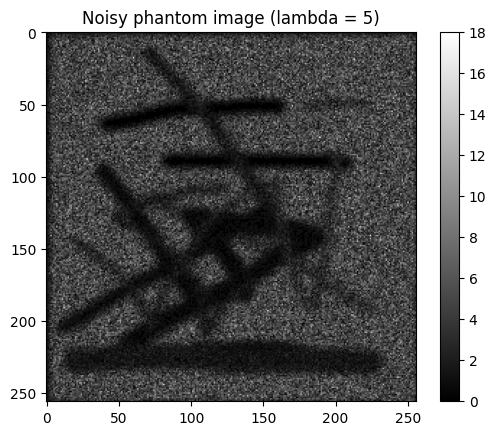

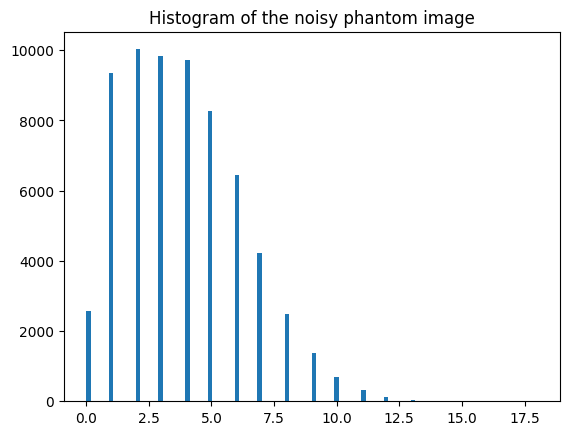

In [9]:
#using poisson noise

Lambda = 5 #fluence value
poisson = np.random.poisson(Lambda, phantom.shape)

# #plot the poisson noise
# plt.imshow(poisson, cmap = plt.get_cmap('gray'))
# plt.title('Poisson noise')
# plt.show()

#add the poisson noise to the image
noisy_phantom = np.multiply(blur_phantom, poisson)
noisy_phantom = np.round(noisy_phantom)

#plot the noisy image
plt.imshow(noisy_phantom, cmap = plt.get_cmap('gray'))
plt.title('Noisy phantom image (lambda = %d)' % Lambda)
plt.colorbar()
plt.show()

# #plot histogram of the noisy image
plt.hist(noisy_phantom.flatten(), bins=100)
plt.title('Histogram of the noisy phantom image')
plt.show()